<div align="center">

# <span style="color: red;">Deep Learining (A.A. 2024-2025)</span>
### *Alberto Lazzeri*
## <span style="color: blue;">Pneumonia Detection using X-Ray images</span>
### *Deep Neural Network trained and evaluated for Pneumonia detection on children.*

</div>

## <span style="color: green;">Introduction</span>
The growing development of deep learning techniques has led in recent years to a significant expansion in their fields of application. Over the past 15 years, various artificial neural network models have been created and applied in the medical-clinical and pharmaceutical fields. In particular, within the clinical domain, the goal is to develop models capable of **performing diagnoses on patients** based on various types of data. This is done to provide support to physicians by automating the diagnostic process, which is often time-consuming and costly.

However, approaching this field comes with a number of challenges, the most relevant of which include:

- **Interpretability**: Deep learning models are often considered "black boxes" because it is difficult to understand how they arrive at their predictions. This is particularly critical in the medical context, where it is essential to understand the reasoning behind a diagnosis or clinical decision.
- **Dataset size and generalization**: Obtaining sufficiently large and representative medical datasets can be challenging. Moreover, models must generalize well to new data to be useful in clinical settings different from those they were trained on.
- **Reliability and safety**: It is crucial that models are reliable and safe. Even small errors or biases in the models can have serious consequences when it comes to medical diagnosis.
- **Clinical validation**: It is essential to conduct thorough clinical studies to validate the effectiveness of deep learning models before they can be adopted in clinical practice. This process requires significant time and resources.

In the paper called ["Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning"](./PIIS0092867418301545.pdf), submitted in 2017 and published in 2018 by [Cell](https://www.cell.com/cell/home), a group of Chinese and American researchers used **transfer learning** with a pre-trained model ([InceptionV3](https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3)) to train an artificial neural network to recognize diabetic retinopathy from optical coherence tomography (OCT) images. They were able to achieve a more transparent and interpretable diagnosis by highlighting the regions of interest predicted by the model. Additionally, they applied the same model to the diagnosis of pneumonia in pediatric patients to evaluate its generalizability.

The aim of this project is to improve the results obtained in diagnosing pneumonia in pediatric patients by training three different models:

- A custom CNN  
- Transfer learning with [DenseNet121](https://keras.io/api/applications/densenet/), recommended for medical images with small datasets  
- Transfer learning with [Xception](https://keras.io/api/applications/xception/), which typically offers higher accuracy

In [2]:
import os
import shutil
from tqdm import tqdm
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from imagehash import average_hash

sns.set_style('darkgrid')

from PIL import Image
from collections import defaultdict
#from skimage.feature import hog
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

In [4]:
print("--- GPU Availability Check (TensorFlow 2.x) ---")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow can access {len(gpus)} GPU(s): {[gpu.name for gpu in gpus]}")
else:
    print("TensorFlow cannot access a GPU. Running on CPU.")

--- GPU Availability Check (TensorFlow 2.x) ---
TensorFlow can access 1 GPU(s): ['/physical_device:GPU:0']


## <span style="color: green;">Data visualization</span>
The dataset contains chest X-ray images of pediatric patients from the Guangzhou Women and Children’s Medical Center, located in Guangzhou. The dataset is available for download at [this link](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). Data visualization and preprocessing methods were adapted from an existing work, which can be found [here](https://www.kaggle.com/code/despoinavoulgari/pneumonia-x-ray-images-rf-cnn-vgg16-98-4), which includes a well-structured data analysis, later improved based on the performance of previous models.

The dataset is divided into three subsets: `train`, `validation`, and `test`. Each subfolder contains images of either healthy lungs (*NORMAL*) or lungs affected by pneumonia (*PNEUMONIA*).

In [10]:
base_dir = "chest_xray"

print(f"Proposed base_dir: {base_dir}")
print(f"Contents of proposed base_dir: {os.listdir(base_dir) if os.path.exists(base_dir) else 'Path does not exist.'}")

# Define the names of the subdirectories within base_dir
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

Proposed base_dir: chest_xray
Contents of proposed base_dir: ['test', 'train', 'val']


In [11]:
def count_images(directory):
    """Count images in directory and its subdirectories"""
    counts = defaultdict(int)
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                class_name = os.path.basename(root)
                counts[class_name] += 1
    return dict(counts)

# Count images in each split
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Print results in a clear table format
table = [
    ["Train", train_counts.get('NORMAL', 0), train_counts.get('PNEUMONIA', 0), sum(train_counts.values())],
    ["Validation", val_counts.get('NORMAL', 0), val_counts.get('PNEUMONIA', 0), sum(val_counts.values())],
    ["Test", test_counts.get('NORMAL', 0), test_counts.get('PNEUMONIA', 0), sum(test_counts.values())],
    ["TOTAL", 
     train_counts.get('NORMAL', 0) + val_counts.get('NORMAL', 0) + test_counts.get('NORMAL', 0),
     train_counts.get('PNEUMONIA', 0) + val_counts.get('PNEUMONIA', 0) + test_counts.get('PNEUMONIA', 0),
     sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())]
]

print(tabulate(table, 
               headers=["Split", "NORMAL", "PNEUMONIA", "Total"], 
               tablefmt="grid",
               numalign="center"))

+------------+----------+-------------+---------+
| Split      |  NORMAL  |  PNEUMONIA  |  Total  |
+============+==========+=============+=========+
| Train      |   1341   |    3875     |  5216   |
+------------+----------+-------------+---------+
| Validation |    8     |      8      |   16    |
+------------+----------+-------------+---------+
| Test       |   234    |     390     |   624   |
+------------+----------+-------------+---------+
| TOTAL      |   1583   |    4273     |  5856   |
+------------+----------+-------------+---------+


### <span style="color: purple;">Dataset distribution analysis</span>
The dataset shows significant class imbalance and split distribution issues:

1. **Class Imbalance**: 
	- Pneumonia cases dominate (4,273) vs Normal (1,583)
2. **Split Problems**: 
	- Validation set is critically small (only 16 images): 8 Normal + 8 Pneumonia samples
	- Far below the recommended is 10-20% of total data
3. **Training Implications**:
	- The tiny validation set cannot provide reliable metrics
	- High risk of overfitting with no meaningful validation
	- Model performance claims will be statistically unreliable

### <span style="color: purple;">Redistribution splits</span>
Create a new directory (`data_redistributed_stratified`) with new split ratios: 70%, 15%, 15%.

In [12]:
# Define new split ratios (70-15-15)
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

def redistribute_data_stratified(base_dir, new_base_dir):
    os.makedirs(new_base_dir, exist_ok=True)
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        # Collect all image paths
        class_path = os.path.join(base_dir, class_name)
        images = [os.path.join(class_path, f) for f in os.listdir(class_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Generate labels (same length as images)
        labels = [class_name] * len(images)
        
        # First split: Train (70%) vs Temp (30%)
        X_train, X_temp, y_train, y_temp = train_test_split(
            images, labels,
            test_size=(VAL_RATIO + TEST_RATIO),  # 30% for val+test
            stratify=labels,  # Critical for class balance
            random_state=42
        )
        
        # Second split: Val (15%) and Test (15%) from Temp
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp,
            test_size=TEST_RATIO/(VAL_RATIO + TEST_RATIO),  # 0.15/0.3 = 0.5
            stratify=y_temp,  # Maintain balance in val/test
            random_state=42
        )
        
        # Copy files to new structure
        for split, paths in zip(['train', 'val', 'test'], [X_train, X_val, X_test]):
            dest_dir = os.path.join(new_base_dir, split, class_name)
            os.makedirs(dest_dir, exist_ok=True)
            for src in tqdm(paths, desc=f'Copying {class_name} to {split}'):
                shutil.copy(src, dest_dir)

# Usage
redistribute_data_stratified(os.path.join(base_dir, 'train'), 'data_redistributed_stratified')

Copying PNEUMONIA to test: 100%|██████████| 582/582 [00:00<00:00, 9536.98it/s]


In [13]:
base_dir = 'data_redistributed_stratified'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

# Get class distribution
def get_class_distribution(directory):
    classes = os.listdir(directory)
    class_counts = {}
    for cls in classes:
        class_path = os.path.join(directory, cls)
        if os.path.isdir(class_path):
            class_counts[cls] = len(os.listdir(class_path))
    return class_counts

train_dist = get_class_distribution(train_dir)
test_dist = get_class_distribution(test_dir)
val_dist = get_class_distribution(val_dir)

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Print results in a clear table format
table = [
    ["Train", train_counts.get('NORMAL', 0), train_counts.get('PNEUMONIA', 0), sum(train_counts.values())],
    ["Validation", val_counts.get('NORMAL', 0), val_counts.get('PNEUMONIA', 0), sum(val_counts.values())],
    ["Test", test_counts.get('NORMAL', 0), test_counts.get('PNEUMONIA', 0), sum(test_counts.values())],
    ["TOTAL", 
     train_counts.get('NORMAL', 0) + val_counts.get('NORMAL', 0) + test_counts.get('NORMAL', 0),
     train_counts.get('PNEUMONIA', 0) + val_counts.get('PNEUMONIA', 0) + test_counts.get('PNEUMONIA', 0),
     sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())]
]

print(tabulate(table, 
               headers=["Split", "NORMAL", "PNEUMONIA", "Total"], 
               tablefmt="grid",
               numalign="center"))

+------------+----------+-------------+---------+
| Split      |  NORMAL  |  PNEUMONIA  |  Total  |
+============+==========+=============+=========+
| Train      |   938    |    2712     |  3650   |
+------------+----------+-------------+---------+
| Validation |   201    |     581     |   782   |
+------------+----------+-------------+---------+
| Test       |   202    |     582     |   784   |
+------------+----------+-------------+---------+
| TOTAL      |   1341   |    3875     |  5216   |
+------------+----------+-------------+---------+


**After the redistribution we have:**

- **Class ratios are consistent**:
	- The distribution of PNEUMONIA (≈74%) vs. NORMAL (≈26%) is almost identical across training, test, and validation sets.
	- This prevents distribution mismatch, where the model performs well on training but poorly on test/validation.
- **Reasonable split sizes**: training set (~3650 samples) is the largest, which is good for learning. Test (~784) and validation (~782) sets are large enough for reliable evaluation.
- **Class Imbalance** (74% vs. 26%). Pneumonia cases dominate, which might bias the model toward predicting "PNEUMONIA" more often.
	- Solution: Use class weights (e.g., class_weight='balanced' in `scikit-learn`) or oversample the minority class (NORMAL).

Check now if there are **copies of the same image between sets**, because could cause overfitting cases across all models and lead to data leakage.

In [14]:
def get_image_hashes(directory):
    """Get hashes of all images in a directory and its subdirectories"""
    hashes = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                try:
                    img_path = os.path.join(root, file)
                    with Image.open(img_path) as img:
                        hashes.append(average_hash(img))
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
    return hashes

# Get hashes for all images
train_hashes = get_image_hashes(train_dir)
val_hashes = get_image_hashes(val_dir)
test_hashes = get_image_hashes(test_dir)

# Find duplicates
duplicates_tr_v = set(train_hashes) & set(val_hashes)
print(f"Number of duplicate images between train and validation found: {len(duplicates_tr_v)}")
duplicates_tr_t = set(train_hashes) & set(test_hashes)
print(f"Number of duplicate images between train and test found: {len(duplicates_tr_t)}")
duplicates_v_t = set(val_hashes) & set(test_hashes)
print(f"Number of duplicate images between validation and test found: {len(duplicates_v_t)}")

Number of duplicate images between train and validation found: 43
Number of duplicate images between train and test found: 51
Number of duplicate images between validation and test found: 15


Results show that:
- Train - Validation (43): model may "cheat" by memorizing validation samples
- Train - Test (51): test metrics become unreliable (false high accuracy)
- Validation - Test (15): reduces independence of evaluation sets

Data show problem of overlapping between the datasets. Identify these pictures throught **average hash** and preserve them to the `train` directory only.

In [15]:
duplicates_dir = os.path.join(base_dir, 'duplicates')
os.makedirs(duplicates_dir, exist_ok=True)

# This will store all unique hashes
unique_hashes = set()

# Process training set first (keep all training images)
for class_name in ['NORMAL', 'PNEUMONIA']:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                h = str(average_hash(img))
                unique_hashes.add(h)
        except:
            continue

# Now process validation/test sets and move duplicates to train
for split_dir in [val_dir, test_dir]:
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_path = os.path.join(split_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                with Image.open(img_path) as img:
                    h = str(average_hash(img))
                    if h in unique_hashes:
                        # Move duplicate to train set
                        dest_dir = os.path.join(train_dir, class_name)
                        shutil.move(img_path, os.path.join(dest_dir, img_name))
                    else:
                        unique_hashes.add(h)
            except:
                continue

print("Duplicate removal complete!")

Duplicate removal complete!


In [16]:
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

# Print results in a clear table format
table = [
    ["Train", train_counts.get('NORMAL', 0), train_counts.get('PNEUMONIA', 0), sum(train_counts.values())],
    ["Validation", val_counts.get('NORMAL', 0), val_counts.get('PNEUMONIA', 0), sum(val_counts.values())],
    ["Test", test_counts.get('NORMAL', 0), test_counts.get('PNEUMONIA', 0), sum(test_counts.values())],
    ["TOTAL", 
     train_counts.get('NORMAL', 0) + val_counts.get('NORMAL', 0) + test_counts.get('NORMAL', 0),
     train_counts.get('PNEUMONIA', 0) + val_counts.get('PNEUMONIA', 0) + test_counts.get('PNEUMONIA', 0),
     sum(train_counts.values()) + sum(val_counts.values()) + sum(test_counts.values())]
]

print(tabulate(table, 
               headers=["Split", "NORMAL", "PNEUMONIA", "Total"], 
               tablefmt="grid",
               numalign="center"))

+------------+----------+-------------+---------+
| Split      |  NORMAL  |  PNEUMONIA  |  Total  |
+============+==========+=============+=========+
| Train      |   985    |    2783     |  3768   |
+------------+----------+-------------+---------+
| Validation |   177    |     552     |   729   |
+------------+----------+-------------+---------+
| Test       |   179    |     540     |   719   |
+------------+----------+-------------+---------+
| TOTAL      |   1341   |    3875     |  5216   |
+------------+----------+-------------+---------+


### <span style="color: purple;">Image dimensions analysis</span>
Image pixels should be in gray scale with values within [0, 255] and not too large or small dimensions.

=== IMAGE STATISTICS ===
Train set:
  Average Pixel Value: 122.82 ± 18.43 (min: 60.69, max: 221.54)
  Width: 1320.16 ± 351.69 pixels
  Height: 965.64 ± 374.90 pixels

Validation set:
  Average Pixel Value: 123.19 ± 18.65 (min: 64.77, max: 201.84)
  Width: 1314.85 ± 358.23 pixels
  Height: 966.64 ± 380.79 pixels

Test set:
  Average Pixel Value: 123.64 ± 18.92 (min: 66.25, max: 185.11)
  Width: 1328.79 ± 370.42 pixels
  Height: 982.32 ± 396.55 pixels


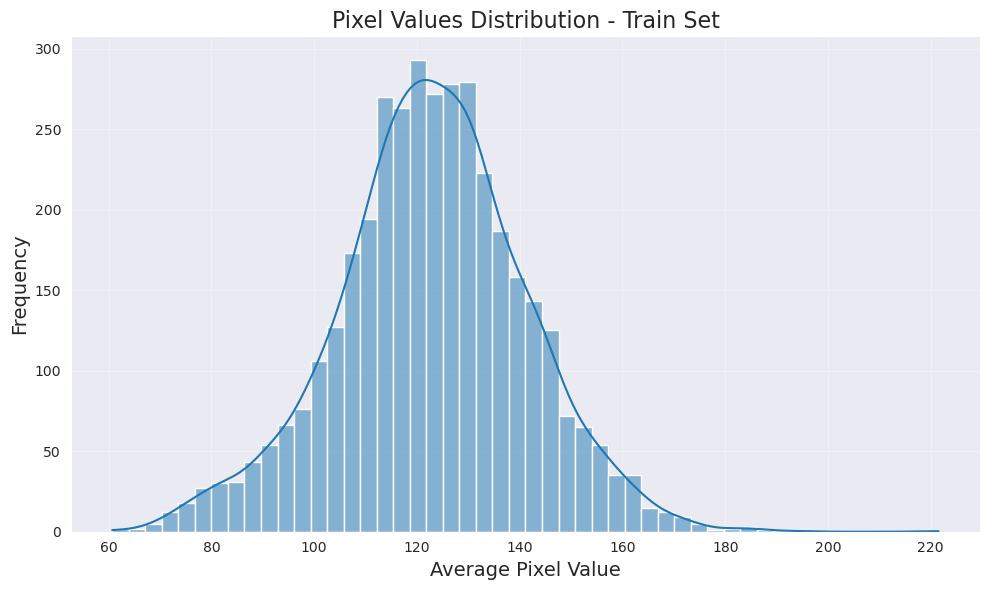

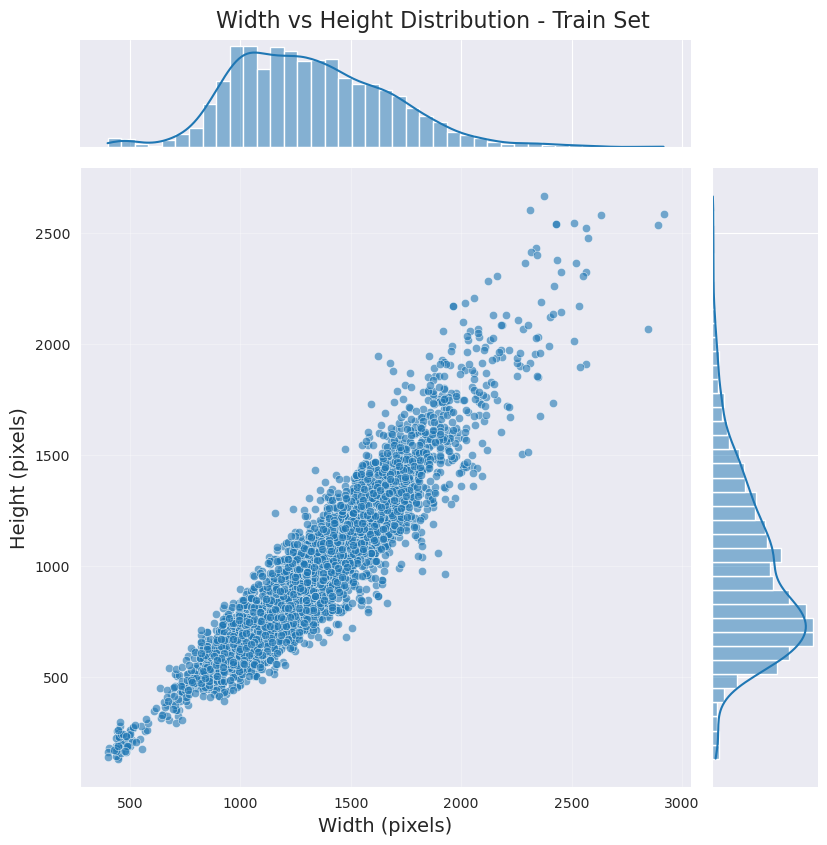

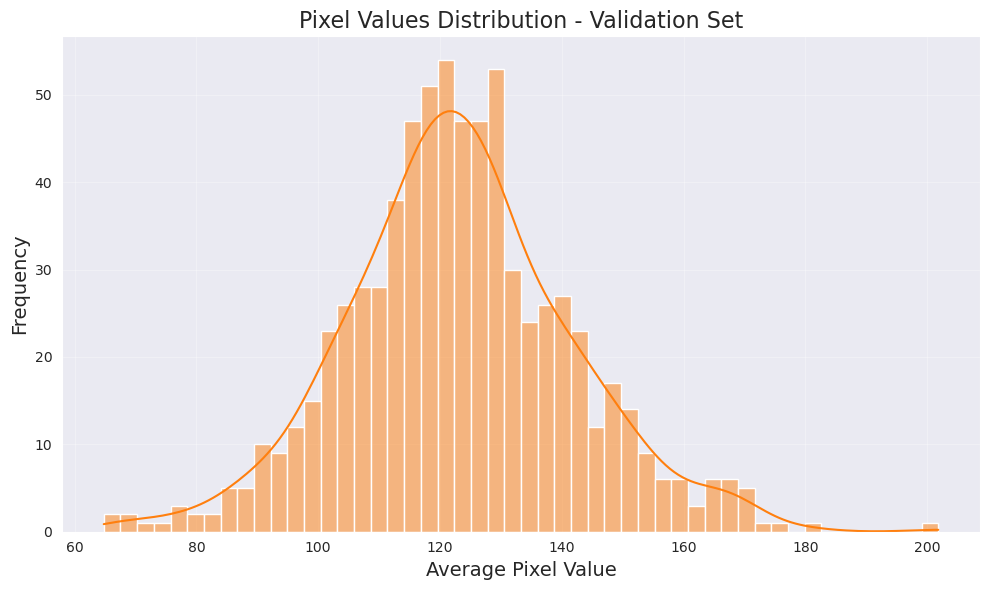

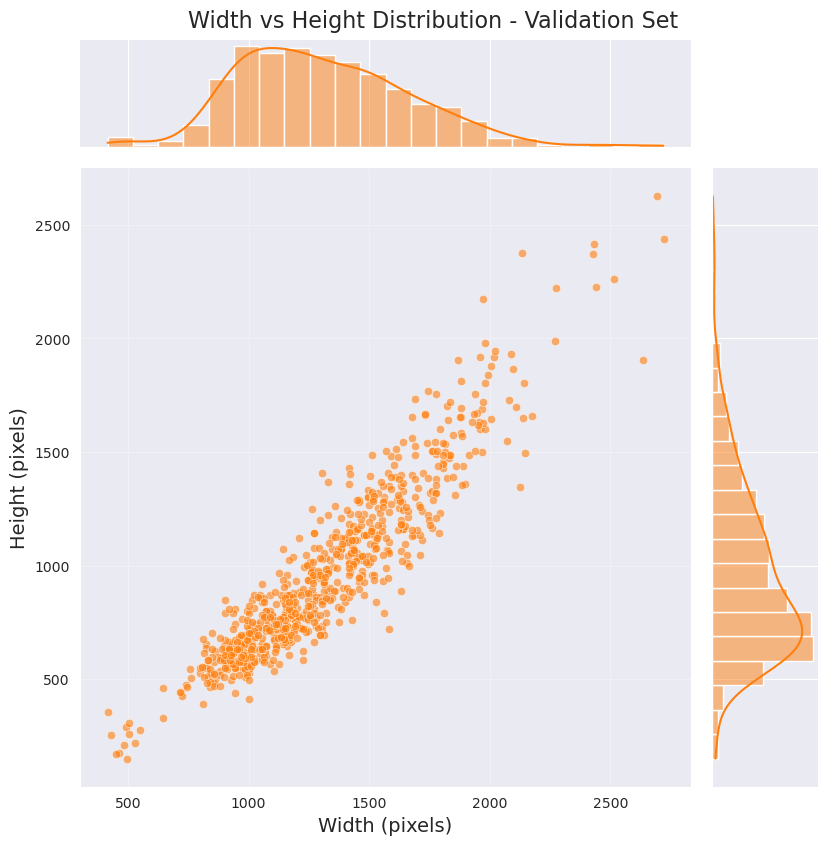

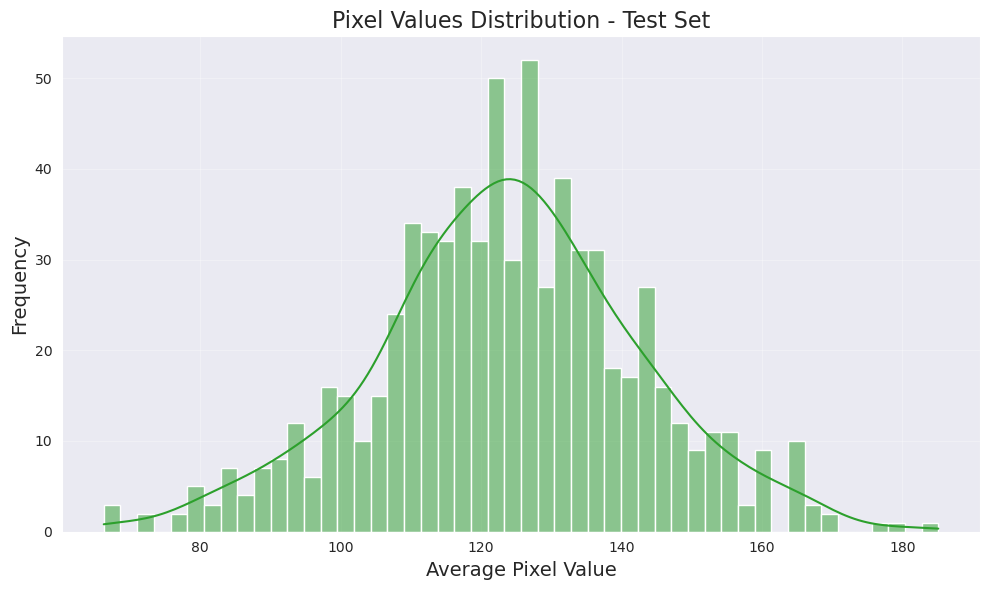

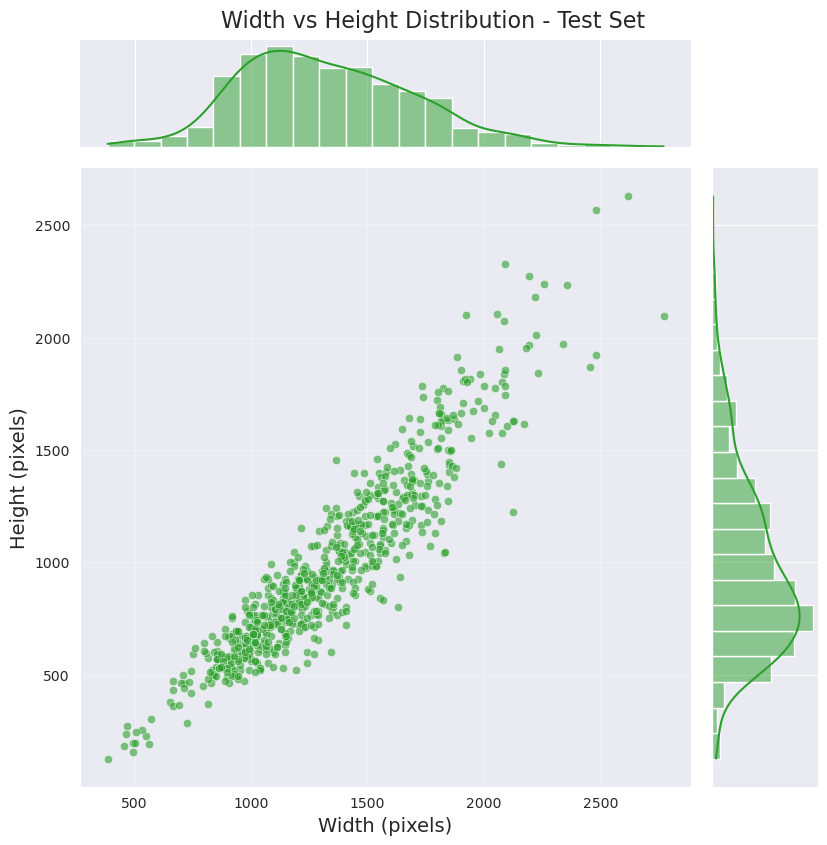

In [28]:
#calculate average pixel value, width and height with standard deviations
def calculate_average_image_dimensions(directory):
	pixel_values = []
	widths = []
	heights = []
	for root, _, files in os.walk(directory):
		for file in files:
			if file.lower().endswith(('.png', '.jpg', '.jpeg')):
				img_path = os.path.join(root, file)
				try:
					with Image.open(img_path) as img:
						# Convert to grayscale if needed and get pixel values
						if img.mode != 'L':
							img = img.convert('L')
						img_array = np.array(img)
						avg_pixel_value = np.mean(img_array)
						pixel_values.append(avg_pixel_value)
						
						# Get dimensions
						width, height = img.size
						widths.append(width)
						heights.append(height)
				except Exception as e:
					print(f"Error processing {img_path}: {str(e)}")
	
	if len(pixel_values) > 0:
		avg_pixel = np.mean(pixel_values)
		std_pixel = np.std(pixel_values)
		min_pixel = np.min(pixel_values)
		max_pixel = np.max(pixel_values)
		avg_width = np.mean(widths)
		std_width = np.std(widths)
		avg_height = np.mean(heights)
		std_height = np.std(heights)
		return avg_pixel, std_pixel, min_pixel, max_pixel, avg_width, std_width, avg_height, std_height
	else:
		return 0, 0, 0, 0, 0, 0, 0, 0

# Calculate dimensions for each split
train_stats = calculate_average_image_dimensions(train_dir)
val_stats = calculate_average_image_dimensions(val_dir)
test_stats = calculate_average_image_dimensions(test_dir)

print("=== IMAGE STATISTICS ===")
print(f"Train set:")
print(f"  Average Pixel Value: {train_stats[0]:.2f} ± {train_stats[1]:.2f} (min: {train_stats[2]:.2f}, max: {train_stats[3]:.2f})")
print(f"  Width: {train_stats[4]:.2f} ± {train_stats[5]:.2f} pixels")
print(f"  Height: {train_stats[6]:.2f} ± {train_stats[7]:.2f} pixels")
print()
print(f"Validation set:")
print(f"  Average Pixel Value: {val_stats[0]:.2f} ± {val_stats[1]:.2f} (min: {val_stats[2]:.2f}, max: {val_stats[3]:.2f})")
print(f"  Width: {val_stats[4]:.2f} ± {val_stats[5]:.2f} pixels")
print(f"  Height: {val_stats[6]:.2f} ± {val_stats[7]:.2f} pixels")
print()
print(f"Test set:")
print(f"  Average Pixel Value: {test_stats[0]:.2f} ± {test_stats[1]:.2f} (min: {test_stats[2]:.2f}, max: {test_stats[3]:.2f})")
print(f"  Width: {test_stats[4]:.2f} ± {test_stats[5]:.2f} pixels")
print(f"  Height: {test_stats[6]:.2f} ± {test_stats[7]:.2f} pixels")

#plot distribution of pixel values and image dimensions
def plot_image_size_distribution(directory, title):
	pixel_values = []
	widths = []
	heights = []
	for root, _, files in os.walk(directory):
		for file in files:
			if file.lower().endswith(('.png', '.jpg', '.jpeg')):
				img_path = os.path.join(root, file)
				try:
					with Image.open(img_path) as img:
						# Convert to grayscale and get pixel values
						if img.mode != 'L':
							img = img.convert('L')
						img_array = np.array(img)
						avg_pixel_value = np.mean(img_array)
						pixel_values.append(avg_pixel_value)
						
						# Get dimensions
						width, height = img.size
						widths.append(width)
						heights.append(height)
				except Exception as e:
					print(f"Error processing {img_path}: {str(e)}")
	
	# Define colors for different sets
	if "Train" in title:
		color = '#1f77b4'  # Blue
	elif "Validation" in title:
		color = '#ff7f0e'  # Orange
	elif "Test" in title:
		color = '#2ca02c'  # Green
	else:
		color = '#d62728'  # Red (default)
	
	# Create two separate figures
	# Figure 1: Histogram of pixel values
	plt.figure(figsize=(10, 6))
	sns.histplot(pixel_values, bins=50, kde=True, color=color)
	plt.title(f"Pixel Values Distribution - {title}", fontsize=16)
	plt.xlabel("Average Pixel Value", fontsize=14)
	plt.ylabel("Frequency", fontsize=14)
	plt.grid(True, alpha=0.3)
	plt.tight_layout()
	plt.show()
	
	# Figure 2: Scatter plot with marginal distributions
	g = sns.JointGrid(x=widths, y=heights, height=8, ratio=5)
	g.plot_joint(sns.scatterplot, alpha=0.6, color=color)
	g.plot_marginals(sns.histplot, kde=True, color=color)
	g.set_axis_labels("Width (pixels)", "Height (pixels)", fontsize=14)
	g.fig.suptitle(f"Width vs Height Distribution - {title}", y=1.02, fontsize=16)
	g.ax_joint.grid(True, alpha=0.3)
	plt.show()

plot_image_size_distribution(train_dir, "Train Set")
plot_image_size_distribution(val_dir, "Validation Set")
plot_image_size_distribution(test_dir, "Test Set")


**Results**:
1. Pixel values:
	- they are within 0-255 interval in gray scale, which is correct normalization
	- Mean value (for train set, similiar for validation and test) is $\mu = 122.82$ and std dev is $\sigma = 18.43$, which gives a balanced distribution since $\frac{255-0}{2} - \sigma \leq \mu \leq \frac{255-0}{2}+\sigma$
2. Average image size
	- is 1320 (width) and 965 (heigth), for train set, but test and validation values are similar
	- Image dimensions are large, which give high resolution and details

### <span style="color: purple;">Image quality analysis</span>
An image quality check now should be done in order to avoid bias or dataset inconsistency. Images should be in gray scale and not in RGB or others. Previous work showed that color discrepancy correlates with label errors.

In [30]:
def check_image_quality(directory):
    problematic = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
            
        for img_file in os.listdir(class_path):
            try:
                img = Image.open(os.path.join(class_path, img_file))
                img.verify()  # Verify integrity
                if img.mode != 'L':  # Check if grayscale
                    problematic.append((class_name, img_file, 'Color mode issue'))
            except Exception as e:
                problematic.append((class_name, img_file, str(e)))
    
    return pd.DataFrame(problematic, columns=['Class', 'Filename', 'Issue'])

quality_issues = check_image_quality(train_dir)
if not quality_issues.empty:
    print("Found image quality issues in train set:")
    display(quality_issues)
else:
    print("No image quality issues detected for train set")
    
quality_issues_val = check_image_quality(val_dir)
if not quality_issues_val.empty:
    print("Found image quality issues in validation set:")
    display(quality_issues_val)
else:
    print("No image quality issues detected for validation set")

quality_issues_test = check_image_quality(test_dir)
if not quality_issues_test.empty:
	print("Found image quality issues in test set:")
	display(quality_issues_test)
else:
	print("No image quality issues detected for test set")

Found image quality issues in train set:


,Class,Filename,Issue
0,PNEUMONIA,person905_bacteria_2830.jpeg,Color mode issue
1,PNEUMONIA,person1644_bacteria_4361.jpeg,Color mode issue
2,PNEUMONIA,person940_virus_1609.jpeg,Color mode issue
3,PNEUMONIA,person421_virus_866.jpeg,Color mode issue
4,PNEUMONIA,person894_bacteria_2819.jpeg,Color mode issue
...,...,...,...
196,PNEUMONIA,person1670_bacteria_4426.jpeg,Color mode issue
197,PNEUMONIA,person347_bacteria_1599.jpeg,Color mode issue
198,PNEUMONIA,person306_virus_628.jpeg,Color mode issue
199,PNEUMONIA,person1197_virus_2039.jpeg,Color mode issue


Found image quality issues in validation set:


,Class,Filename,Issue
0,PNEUMONIA,person630_virus_1209.jpeg,Color mode issue
1,PNEUMONIA,person1170_virus_1969.jpeg,Color mode issue
2,PNEUMONIA,person1131_bacteria_3073.jpeg,Color mode issue
3,PNEUMONIA,person528_bacteria_2227.jpeg,Color mode issue
4,PNEUMONIA,person1133_virus_1865.jpeg,Color mode issue
5,PNEUMONIA,person663_virus_1247.jpeg,Color mode issue
6,PNEUMONIA,person819_virus_1455.jpeg,Color mode issue
7,PNEUMONIA,person1186_virus_2021.jpeg,Color mode issue
8,PNEUMONIA,person282_virus_579.jpeg,Color mode issue
9,PNEUMONIA,person734_virus_1355.jpeg,Color mode issue


Found image quality issues in test set:


,Class,Filename,Issue
0,PNEUMONIA,person430_virus_879.jpeg,Color mode issue
1,PNEUMONIA,person466_bacteria_1984.jpeg,Color mode issue
2,PNEUMONIA,person309_virus_631.jpeg,Color mode issue
3,PNEUMONIA,person407_virus_811.jpeg,Color mode issue
4,PNEUMONIA,person1177_virus_2001.jpeg,Color mode issue
5,PNEUMONIA,person1220_virus_2068.jpeg,Color mode issue
6,PNEUMONIA,person1308_bacteria_3280.jpeg,Color mode issue
7,PNEUMONIA,person1263_bacteria_3221.jpeg,Color mode issue
8,PNEUMONIA,person508_virus_1020.jpeg,Color mode issue
9,PNEUMONIA,person1642_bacteria_4352.jpeg,Color mode issue


**Results**:
1. All problematic images are from the same class: Pneumonia
	- This suggests a systematic data collection or processing artifact

However this images will be kept, otherwise dataset will be even smaller. Here there are some examples between a Issued image and a standard image.

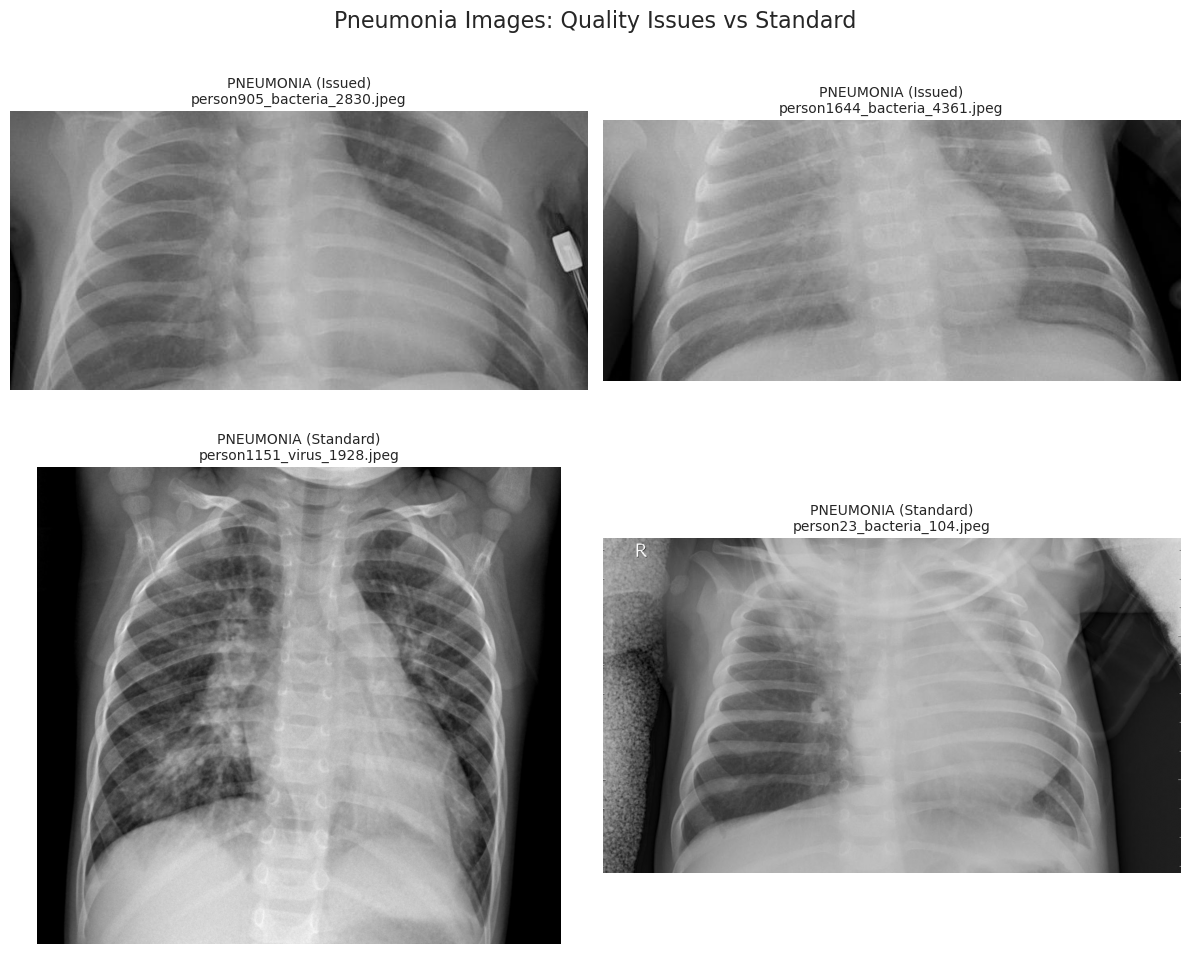

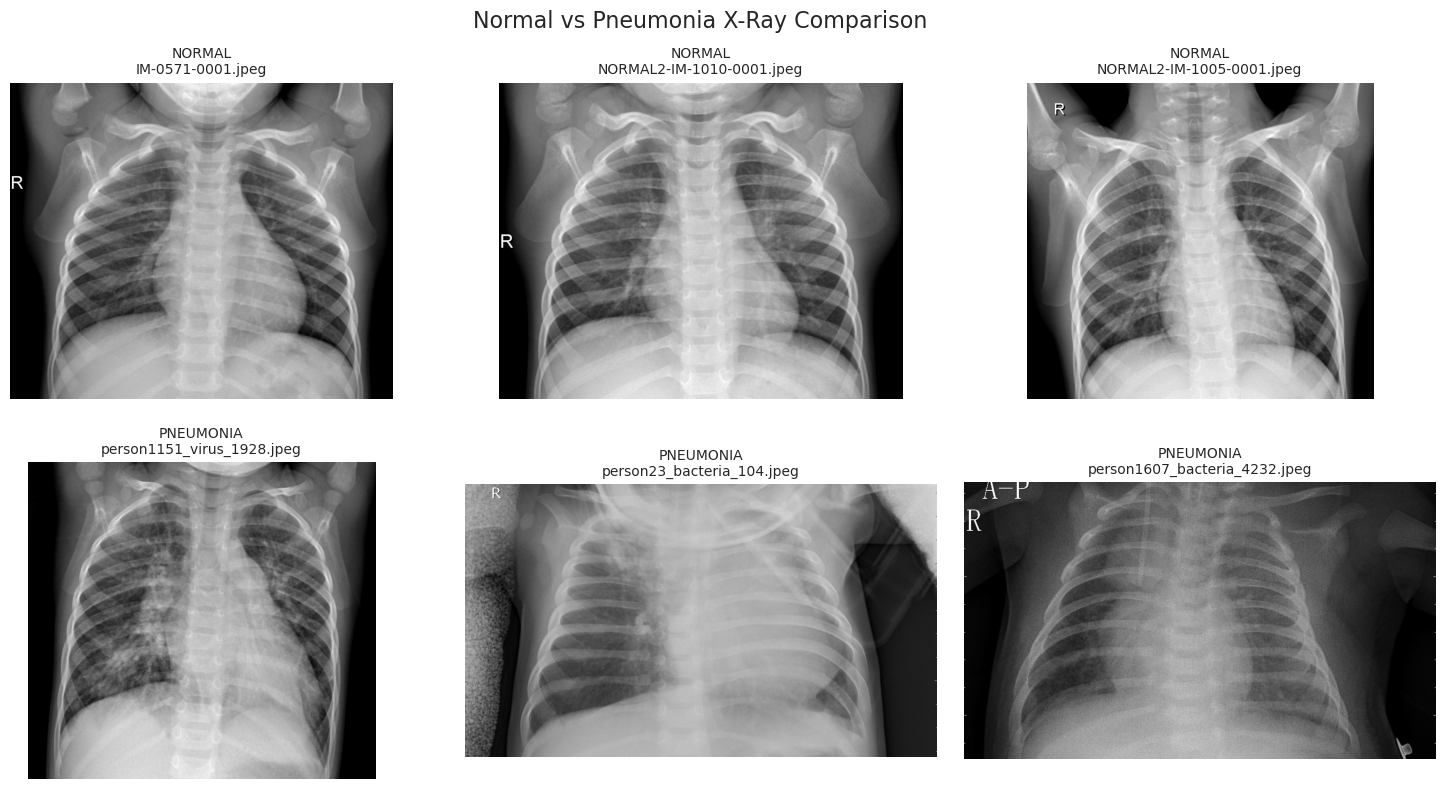

In [40]:
# Plot comparison between issued and non-issued pneumonia images
def plot_pneumonia_quality_comparison(directory):
    pneumonia_path = os.path.join(directory, 'PNEUMONIA')
    all_images = os.listdir(pneumonia_path)
    issued_images = []
    non_issued_images = []
    for img_file in all_images:
        try:
            img_path = os.path.join(pneumonia_path, img_file)
            img = Image.open(img_path)
            if img.mode != 'L':
                issued_images.append(img_file)
            else:
                non_issued_images.append(img_file)
        except:
            continue
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))    
    # Plot issued pneumonia images
    for i in range(2):
        if i < len(issued_images):
            img_path = os.path.join(pneumonia_path, issued_images[i])
            img = Image.open(img_path)
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(f"PNEUMONIA (Issued)\n{issued_images[i]}", fontsize=10)
            axes[0, i].axis('off')
    
    # Plot non-issued pneumonia images
    for i in range(2):
        if i < len(non_issued_images):
            img_path = os.path.join(pneumonia_path, non_issued_images[i])
            img = Image.open(img_path)
            axes[1, i].imshow(img, cmap='gray')
            axes[1, i].set_title(f"PNEUMONIA (Standard)\n{non_issued_images[i]}", fontsize=10)
            axes[1, i].axis('off')
    
    plt.suptitle("Pneumonia Images: Quality Issues vs Standard", fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

# Plot comparison between normal and pneumonia classes
def plot_class_comparison(directory, num_images=3):
    fig, axes = plt.subplots(2, num_images, figsize=(15, 8))
    
    for i, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
        class_path = os.path.join(directory, class_name)
        images = os.listdir(class_path)[:num_images]
        
        for j, img_file in enumerate(images):
            ax = axes[i,j]
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            ax.imshow(img, cmap='gray')
            ax.set_title(f"{class_name}\n{img_file}", fontsize=10)
            ax.axis('off')
    
    plt.suptitle("Normal vs Pneumonia X-Ray Comparison", fontsize=16, y=0.98)
    plt.tight_layout(h_pad=2.0, w_pad=2.0)  # Vertical and horizontal padding
    plt.show()

# Execute the plots
plot_pneumonia_quality_comparison(train_dir)
plot_class_comparison(train_dir)

## <span style="color: green;">Transfer learning</span>
**Transfer learning** is a machine learning technique where a model developed for a specific task is reused as the starting point for a model on a second, related task. In deep learning, it typically involves **taking a pre-trained model**, usually trained on a large dataset like ImageNet, and fine-tuning it on a smaller, task-specific dataset.

This approach is especially useful when labeled data is limited, as in this case. It allows the model to leverage learned features (such as edges, textures, or shapes) from the original training task, **improving performance and reducing training time**.

In the past years some pre-trained models for image classification (and similar tasks) were developed (from Google, Facebook, Keras and others...) and trained on large dataset from [ImageNet](https://www.image-net.org/).

All of these models are based on Convolutional Neural Networks (CNNs) and differ in terms of:

- **Core structure** (e.g., linear, modular, etc.) and **architectural complexity** (e.g., number of layers, number of parameters, etc.)
- **Efficiency and speed**
- **Accuracy and generalization capabilities**

The choice of the most suitable pre-trained model for a specific problem depends on several factors. In this case, the most important are:

1. A reduced number of parameters and low RAM/GPU usage  
2. A good trade-off between accuracy and efficiency  
3. Strong performance on high-resolution grayscale medical images  

The [Keras 3 API Applications page](https://keras.io/api/applications/) includes the most widely used pre-trained models and provides easy access to them.


### <span style="color: purple;">DenseNet121</span>

*to do list*
- Data loading and cache
- Data augmentation
- Describe models and define architecture

### <span style="color: purple;">Xception</span>